# Dynamic Flux Balance Analysis

Up until now, the generated results have only been static results created under a set of specific conditions.
The Dynamic Flux Balance Analysis (DFBA) incorporates a time dimension, allowing the modeling and simulation of the dynamic processes in the GSM model. While traditional FBA assumes steady-state conditions, DFBA considers changes over time by integrating a time-dependent component into the model.

In [1]:
# Initialising packages
import numpy as np
from tqdm import tqdm # For creating nice progess bars 
from scipy.integrate import solve_ivp # See description when function is used
import matplotlib.pyplot as plt
import cobra
from cobra.io import read_sbml_model
%matplotlib inline

In [2]:
model = read_sbml_model('data/iYO844_modified.xml')
# Setting up the mathematical programming solver for optimisation
model.solver = "glpk" # Free source GLPK (GNU Linear Programming Kit)

The following functions have been modified from COBRApy's own documentation. 

In [3]:
# Defining function to add dynamic bounds for glucose and biomass
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose, DHAA = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import
 
# Defining function to calculate the time derivative of external species
def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose, DHAA = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['BIOMASS_BS_10', 'EX_glc__D_e','ALDH1_CYP71AV1'], ['max', 'max', 'min'])
 
    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass
 
    # This implementation is *not* efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None
 
# Defining event function to check feasibility
def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)
        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
    

    return feasibility - infeasible_event.epsilon

 
infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [4]:
# Performing the simulation
# Time span and initial conditions
ts = np.linspace(0, 15, 100)  # Desired integration resolution and interval
y0 = [0.1, 10, 0] # Start values for biomass, glucose and DHAA, respectively.

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 5.999: : 196it [25:42,  7.87s/it]


In [5]:
sol

  message: 'A termination event occurred.'
     nfev: 186
     njev: 2
      nlu: 15
      sol: None
   status: 1
  success: True
        t: array([0.        , 0.15151515, 0.3030303 , 0.45454545, 0.60606061,
       0.75757576, 0.90909091, 1.06060606, 1.21212121, 1.36363636,
       1.51515152, 1.66666667, 1.81818182, 1.96969697, 2.12121212,
       2.27272727, 2.42424242, 2.57575758, 2.72727273, 2.87878788,
       3.03030303, 3.18181818, 3.33333333, 3.48484848, 3.63636364,
       3.78787879, 3.93939394, 4.09090909, 4.24242424, 4.39393939,
       4.54545455, 4.6969697 , 4.84848485, 5.        , 5.15151515,
       5.3030303 , 5.45454545, 5.60606061, 5.75757576, 5.90909091])
 t_events: [array([5.99523514])]
        y: array([[1.00000000e-01, 1.08840972e-01, 1.18423881e-01, 1.28803234e-01,
        1.40035659e-01, 1.52179806e-01, 1.65295902e-01, 1.79445166e-01,
        1.94688901e-01, 2.11087644e-01, 2.28700096e-01, 2.47581037e-01,
        2.67780306e-01, 2.89338677e-01, 3.12286472e-01, 3.3663

### Plotting the timelimes of biomass, glucose and DHAA

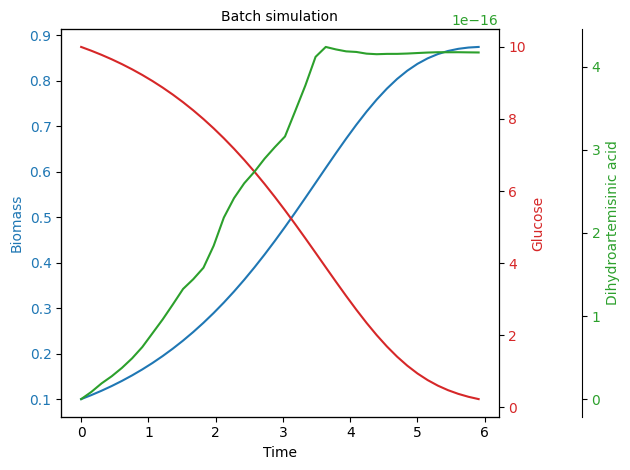

In [6]:
# Plot of the DFBA result
fig, ax1 = plt.subplots()
 
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Biomass', color=color)
ax1.plot(sol.t, sol.y[0], color=color)
ax1.tick_params(axis='y', labelcolor=color)
 
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Glucose', color=color)
ax2.plot(sol.t, sol.y[1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
 
ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # adjust position of the third axis
ax3.set_ylabel('Dihydroartemisinic acid', color=color)
ax3.plot(sol.t, sol.y[2], color=color)
ax3.tick_params(axis='y', labelcolor=color)
 
plt.title('Batch simulation',fontsize=10)
fig.tight_layout()
plt.savefig('figures/DFBA_simulation')
plt.show()